In [1]:
import warnings
import pandas as pd
import statistics as st
import matplotlib.pyplot as plt
import numpy as np

import math

import scipy.stats as sp

warnings.filterwarnings("ignore")

In [139]:
# código utilizado para geração de imagens em LaTeX
"""
%%capture
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

plt.rcParams.update({"text.usetex":True})
plt.rcParams["font.family"] = "Times New Roman"
"""



# Teste de Aderência em Coluna service_length



## 1. Leitura da Base de Dados

In [2]:
url = "simulated_call_centre.csv"
df = pd.read_csv(url)
df = df.drop(columns=["call_id","daily_caller","call_answered","call_ended"])
df.sample(10,random_state=40)

,date,call_started,wait_length,service_length,meets_standard
17737,2021-06-07,8:38:01 AM,0,152,True
13331,2021-05-03,8:55:30 AM,0,425,True
43274,2021-11-18,12:51:31 PM,353,275,False
51004,2021-12-29,12:21:06 PM,602,695,False
35200,2021-10-04,11:50:43 AM,0,205,True
42104,2021-11-11,4:04:55 PM,160,545,False
7665,2021-03-15,11:46:40 AM,0,512,True
28266,2021-08-20,11:28:05 AM,0,427,True
25900,2021-08-04,5:43:25 PM,0,39,True
31600,2021-09-10,3:21:07 PM,0,4,True


In [141]:
# Recorte da base (pior dia)
day_string = df.groupby('date')['wait_length'].sum().idxmax()
df_day = df[df["date"] == day_string]

In [142]:
data = df_day['service_length'].tolist()

## 2. Estatística Descritiva

### 2.1 Medidas de centralidade

In [143]:
print(f'Média: {st.mean(data)}')
print(f'Moda: {st.mode(data)}')
print(f'Mediana: {st.median(data)}')
print(f'Máximo: {max(data)}')
print(f'Mínimo: {min(data)}')

#Quartis
data_sorted = sorted(data)
Q2 = st.quantiles(data_sorted)
print(f'Quartis: {Q2}')

amp = max(data)-min(data)
print(f'Amplitude: {amp}')

var = st.variance(data)
print(f'Variância: {var}')

std = st.stdev(data)
print(f'Desvio padrão: {std}')

var_coef = (std / var)
print(f'Coeficiente de variação: {var_coef}') ###

ass_coef = st.median(data[:len(data)//2]) / (st.median(data)**3/2) ###
print(f'Coeficiente de Assimetria: {ass_coef}')

Média: 324.8316498316498
Moda: 68
Mediana: 232
Máximo: 2244
Mínimo: 1
Quartis: [106.0, 232.0, 455.0]
Amplitude: 2243
Variância: 91563.34994084993
Desvio padrão: 302.5943653488114
Coeficiente de variação: 0.0033047542007177307
Coeficiente de Assimetria: 4.0441515642297755e-05


## 3. Análise e remoção de outliers

### 3.1 Remoção de outliers

In [144]:
# Gerar os quartis
Q = st.quantiles(data_sorted)
A = Q[2] - Q[0]
print(f'Quartis: {Q}')
print(f'Amplitude Interquartil: {A}')

moderado = []
extremo = []
for i in data:
    if i < Q[0]-1.5*A or i > Q[2]+1.5*A: moderado.append(i)
    if i < Q[0]-3*A or i > Q[2]+3*A: extremo.append(i)

print(f' {len(moderado)} outlier(s) moderado(s)\n',moderado,'\n\n',f'{len(extremo)} outlier(s) extremo(s)\n',extremo)

Quartis: [106.0, 232.0, 455.0]
Amplitude Interquartil: 349.0
 9 outlier(s) moderado(s)
 [1221, 1057, 1406, 1554, 1234, 1114, 1111, 1385, 2244] 

 2 outlier(s) extremo(s)
 [1554, 2244]


In [145]:
filtered_data = data.copy()
for i in extremo:
    filtered_data.remove(i)

### 3.2 Novas Medidas

In [146]:
print(f'média: {st.mean(filtered_data)}')
print(f'moda: {st.mode(filtered_data)}')
print(f'mediana: {st.median(filtered_data)}')
print(f'máximo: {max(filtered_data)}')
print(f'mínimo: {min(filtered_data)}')

#Quartis
data_sorted = sorted(filtered_data)
Q2 = st.quantiles(data_sorted)
print(f'Quartis: {Q2}')

amp = max(filtered_data)-min(filtered_data)
print(f'Amplitude: {amp}')

var = st.variance(filtered_data)
print(f'Variância: {var}')

std = st.stdev(filtered_data)
print(f'Desvio padrão: {std}')

var_coef = (std / var)
print(f'Coeficiente de variação: {var_coef}') ###

ass_coef = st.median(filtered_data[:len(filtered_data)//2]) / (st.median(filtered_data)**3/2) ###
print(f'Coeficiente de Assimetria: {ass_coef}')

média: 314.1593220338983
moda: 68
mediana: 229
máximo: 1406
mínimo: 1
Quartis: [105.0, 229.0, 449.0]
Amplitude: 1405
Variância: 74405.06636688573
Desvio padrão: 272.77292088271105
Coeficiente de variação: 0.0036660530552810543
Coeficiente de Assimetria: 4.196856204964465e-05


## 4. Teste de Aderência (Método KS)

### 4.1 Histograma

In [163]:
# Histograma
def histograma(data,show_extra=False):
    plt.title('Boxplot')
    plt.boxplot(data)
    plt.show()

    k = round(1+3.3*math.log10(len(data)))
    print('Número de classes:',k)

    h = (max(data)-min(data)) / k
    print('Tamanho do intervalo:',h)

    if show_extra:
        c,b=np.histogram(data)
        print("tamanho das classes: ",c)
        print("intervalos:",b)

    plt.hist(data, bins=k,edgecolor="black")
    plt.xlabel("Intervalos")
    plt.ylabel("Tempo de Serviço")
    plt.savefig("Histograma.pdf", format="pdf", bbox_inches="tight")
    plt.show()

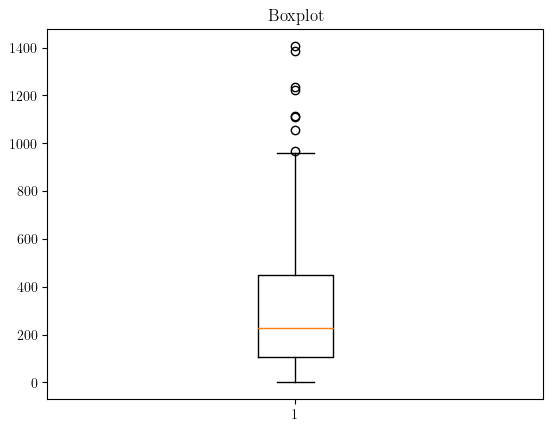

Número de classes: 9
Tamanho do intervalo: 156.11111111111111
tamanho das classes:  [96 73 48 28 23  9 11  3  2  2]
intervalos: [1.0000e+00 1.4150e+02 2.8200e+02 4.2250e+02 5.6300e+02 7.0350e+02
 8.4400e+02 9.8450e+02 1.1250e+03 1.2655e+03 1.4060e+03]


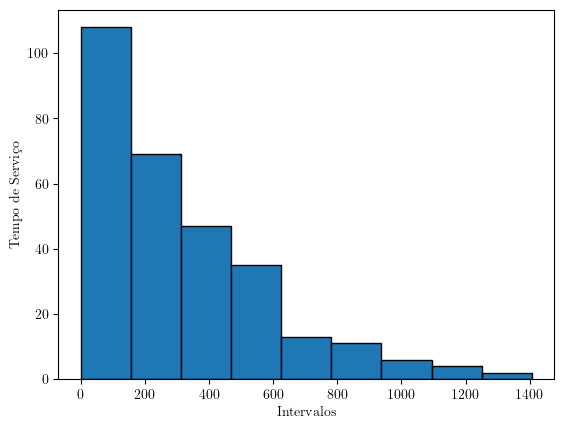

In [164]:
histograma(filtered_data,True)

### 4.2 Função do Teste de Kolmogorov-Smirnov

método para alpha = 0.05

In [149]:
def KS(data,func = None): # método ks para alpha = 0.05
    df = pd.DataFrame()

    list_ = data.copy()

    sum = 0
    FAO = []
    FAON = []
    s_data = sorted(list_)
    size = len(list_)

    VO = list(dict.fromkeys(s_data))
    FO = pd.Series(s_data).value_counts().sort_index(ascending=True).tolist()

    for i in FO:
        sum += i
        FAO.append(sum)
        div = sum/size
        FAON.append(div)

    df['V.O.'] = VO
    df['F.O.'] = FO
    df['F.A.O.'] = FAO
    df['F.A.O.N.'] = FAON

    if func == "uniforme":
        a = df['V.O.'].min()
        b = df['V.O.'].max()

        df['F.T.A.N.'] = sp.uniform.cdf(df['V.O.'].tolist(),loc = a,scale = b)

    elif func == "exponencial":
        mean = st.mean(list_)

        df['F.T.A.N.'] = sp.expon.cdf(df['V.O.'].tolist(),scale = mean)

    elif func == "normal":
        MU = st.mean(list_)
        SIGMA = st.stdev(list_)

        df['F.T.A.N.'] = sp.norm.cdf(df['V.O.'].tolist(),loc=MU,scale=SIGMA)
    else:
        raise TypeError("Função de distribuição inválida")

    df['D'] = abs(df['F.A.O.N.'] - df['F.T.A.N.'])

    # Procurando o alpha, o maior valor da coluna D na tabela

    alpha = max(df['D'])
    print('Valor de α:',alpha)

    D_crit = lambda x: 1.36 / math.sqrt(x)
    print('Valor de D crítico',D_crit(size))

    if D_crit(len(list_)) > alpha:
        print('Como o D crítico > α, então a distribuição aderente ao conjunto de dados.')
    else:
        print('A distribuição não é aderente ao conjunto de dados.')

    return df

In [150]:
ks_df = KS(filtered_data,"exponencial")

Valor de α: 0.052893748612646646
Valor de D crítico 0.07918226132458316
Como o D crítico > α, então a distribuição aderente ao conjunto de dados.


### 4.3 Resultados

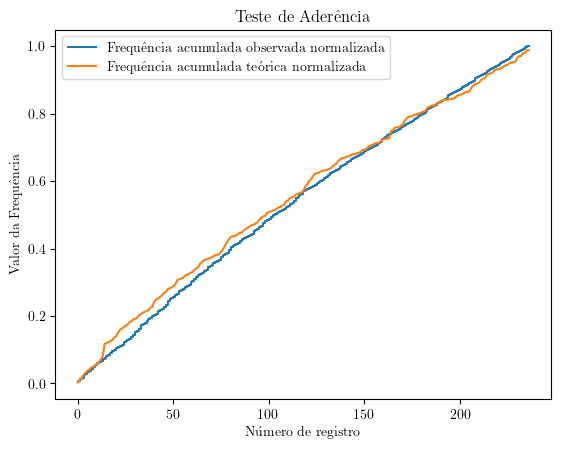

In [151]:
plt.title('Teste de Aderência')
plt.plot(ks_df['F.A.O.N.'],label = 'Frequência acumulada observada normalizada',ds = "steps")
plt.plot(ks_df['F.T.A.N.'],label = 'Frequência acumulada teórica normalizada')
plt.xlabel("Número de registro")
plt.ylabel("Valor da Frequência")
plt.legend()
plt.savefig("Teste de Aderência.pdf", format="pdf", bbox_inches="tight")
plt.show()

## Simulação com SimPy

In [152]:
!pip install simpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [153]:
#import random as rd
import simpy
from datetime import datetime

### Funções auxiliares

In [154]:
def convert_to_seconds(time_string): # converte string do tipo 8:38:01 AM para seu valor em segundos
    time_obj = datetime.strptime(time_string, "%I:%M:%S %p")
    time_in_seconds = (time_obj.hour * 3600) + (time_obj.minute * 60) + time_obj.second
    return time_in_seconds

def subtract(time_seconds):
    return time_seconds - 28800

def standard(wait_time): # determina a conformidade com o padrão do tempo de espera de 60 segundos
    return int(wait_time) <= 60

def percentage(number1, number2): # retorna a porcentagem de dois valores pelo seu total
    percentage1 = (number1 / (number1 + number2)) * 100
    percentage2 = (number2 / (number1 + number2)) * 100
    return percentage1, percentage2

In [155]:
df_day['call_started'] = df_day['call_started'].apply(convert_to_seconds)
df_day['call_started'] = df_day['call_started'].apply(subtract)
df_day

,date,call_started,wait_length,service_length,meets_standard
47359,2021-12-10,0,0,579,True
47360,2021-12-10,139,0,253,True
47361,2021-12-10,174,0,693,True
47362,2021-12-10,398,0,68,True
47363,2021-12-10,560,0,109,True
...,...,...,...,...,...
47651,2021-12-10,35277,14,385,True
47652,2021-12-10,35518,0,409,True
47653,2021-12-10,35535,0,17,True
47654,2021-12-10,35543,10,41,True


In [156]:
# remoção de outliers nos dados de entrada da simulação
start = df_day['call_started'].tolist()
lenght = df_day['service_length'].tolist()

start_length = zip(start,lenght)
start_length = [(i,j) for i,j in start_length if j != 1554 and j != 2244] # outliers determinados no método KS

### Código da simulação

In [157]:
#variáveis da simulação
NUM_ATENDENTES = 4
SIM_TIME = 99999

In [158]:
class CallCentre:

    def __init__(self,env,num_atendentes):
        self.env = env
        self.atendente = simpy.Resource(env,num_atendentes)
        self.espera = []

    def atendimento(self,execution_time): # executa o tempo de atendimento
        yield self.env.timeout(execution_time)

def cliente(env,nome,execution_time,cc): # gera um cliente

    with cc.atendente.request() as request:
        atendimento_solicitado = env.now
        print(f"Cliente {nome} solicita atendimento aos {atendimento_solicitado} segundos") # entra na simulação

        yield request
        atendimento_iniciado = env.now
        cc.espera.append(str(atendimento_iniciado - atendimento_solicitado))
        print(f"Cliente {nome} inicia atendimento aos {atendimento_iniciado} segundos") # é atendido

        yield env.process(cc.atendimento(execution_time))
        print(f"Cliente {nome} desliga aos {env.now} segundos") # sai da simulação

def run(env,cc): # executa a simulação
    nome = 0
    time_var = 0
    for start_time,execution_time in start_length:

        yield env.timeout(start_time-time_var)
        time_var = start_time
        nome += 1
        env.process(cliente(env,nome,execution_time,cc))

In [159]:
env = simpy.Environment()
call_centre = CallCentre(env,NUM_ATENDENTES)

env.process(run(env,call_centre))

print("saída:")
env.run(until=SIM_TIME)

result = pd.DataFrame(columns=['sim_wait_time','sim_meet_standard'])

result['sim_wait_time'] = call_centre.espera
result['sim_meet_standard'] = result['sim_wait_time'].apply(standard)

prob_sim1 = result['sim_meet_standard'].value_counts()

true_values_1 = percentage(prob_sim1[True],prob_sim1[False])
print(f"Porcentagem atendeu padrão: {true_values_1[0]}\nPorcentagem não atendeu padrão {true_values_1[1]}")

saída:
Cliente 1 solicita atendimento aos 0 segundos
Cliente 1 inicia atendimento aos 0 segundos
Cliente 2 solicita atendimento aos 139 segundos
Cliente 2 inicia atendimento aos 139 segundos
Cliente 3 solicita atendimento aos 174 segundos
Cliente 3 inicia atendimento aos 174 segundos
Cliente 2 desliga aos 392 segundos
Cliente 4 solicita atendimento aos 398 segundos
Cliente 4 inicia atendimento aos 398 segundos
Cliente 4 desliga aos 466 segundos
Cliente 5 solicita atendimento aos 560 segundos
Cliente 5 inicia atendimento aos 560 segundos
Cliente 1 desliga aos 579 segundos
Cliente 6 solicita atendimento aos 587 segundos
Cliente 6 inicia atendimento aos 587 segundos
Cliente 5 desliga aos 669 segundos
Cliente 6 desliga aos 704 segundos
Cliente 3 desliga aos 867 segundos
Cliente 7 solicita atendimento aos 1308 segundos
Cliente 7 inicia atendimento aos 1308 segundos
Cliente 8 solicita atendimento aos 1366 segundos
Cliente 8 inicia atendimento aos 1366 segundos
Cliente 9 solicita atendimento 

### Melhoria no atendimento

Aumento de um atendente para suprir demanda

In [160]:
env = simpy.Environment()
call_centre = CallCentre(env,NUM_ATENDENTES+1) # aumento do número de atendentes

espera = env.process(run(env,call_centre))

print("saída:")
env.run(until=SIM_TIME)

result = pd.DataFrame(columns=['sim_wait_time','sim_meet_standard'])

result['sim_wait_time'] = call_centre.espera
result['sim_meet_standard'] = result['sim_wait_time'].apply(standard)

prob_sim2 = result['sim_meet_standard'].value_counts()

true_values_2 = percentage(prob_sim2[True],prob_sim2[False])
print(f"Porcentagem de padrão: {true_values_2[0]}\nPorcentagem não atendida {true_values_2[1]}")

saída:
Cliente 1 solicita atendimento aos 0 segundos
Cliente 1 inicia atendimento aos 0 segundos
Cliente 2 solicita atendimento aos 139 segundos
Cliente 2 inicia atendimento aos 139 segundos
Cliente 3 solicita atendimento aos 174 segundos
Cliente 3 inicia atendimento aos 174 segundos
Cliente 2 desliga aos 392 segundos
Cliente 4 solicita atendimento aos 398 segundos
Cliente 4 inicia atendimento aos 398 segundos
Cliente 4 desliga aos 466 segundos
Cliente 5 solicita atendimento aos 560 segundos
Cliente 5 inicia atendimento aos 560 segundos
Cliente 1 desliga aos 579 segundos
Cliente 6 solicita atendimento aos 587 segundos
Cliente 6 inicia atendimento aos 587 segundos
Cliente 5 desliga aos 669 segundos
Cliente 6 desliga aos 704 segundos
Cliente 3 desliga aos 867 segundos
Cliente 7 solicita atendimento aos 1308 segundos
Cliente 7 inicia atendimento aos 1308 segundos
Cliente 8 solicita atendimento aos 1366 segundos
Cliente 8 inicia atendimento aos 1366 segundos
Cliente 9 solicita atendimento 

In [161]:
result_percentage = pd.DataFrame({
    "simulação":['simulação inicial','simulação inicial','simulação final','simulação final'],
    "atende padrão":[True,False,True,False],
    "porcentagem":[true_values_1[0],true_values_1[1],true_values_2[0],true_values_2[1]]})

result_percentage.set_index(["simulação", result_percentage.index], inplace=True)
result_percentage

atende padrão  porcentagem
simulação                                      
simulação inicial 0           True    74.237288
                  1          False    25.762712
simulação final   2           True    91.525424
                  3          False     8.474576